# 타이타닉 생존률 예측 2차전

파생변수를 생성하여 분석모형 만들기

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(work_path)

from help_a.util import *
from help_a.plot import *
from help_a.analysis import *
from help_a.classification import *

# 정규표현식 처리 패키지
import re

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/edadata/titanic.xlsx", index_col='PassengerId', categories=['Survived', 'Pclass', 'Sex', 'Embarked'], info=False)

### [3] 원본 데이터 프레임 복사

데이터 전처리를 하는 동안 원본을 보관할 목적

In [3]:
df = origin.copy()

## #02. 데이터 전처리

### [1] 나이

탐색적 데이터 분석 과정에서 나이가 생존 여부에 유의미한 차이를 보이는 것으로 판단되었으므로 나이에 대한 결측치를 무조건적인 평균보다 생존자의 평균나이와 사망자의 평균 나이로 나누어서 처리하는 것이 좋을 것이다.

#### (1) 생존자 평균 나이

In [4]:
mean_age_df = df[['Survived','Age']].groupby('Survived').mean()
mean_age_df

,Age
Survived,
0,30.510986
1,28.931079


#### (2) 사망자 평균 나이

In [5]:
for i in mean_age_df.index:
    mean_age = round(mean_age_df.loc[i]['Age'], 0)
    #print(mean_age)

    expr = (df['Survived'] == i) & (df['Age'].isna())
    df.loc[expr, 'Age'] = df.loc[expr, 'Age'].fillna(mean_age)

df['Age'].isna().sum()

0

#### (3) 결측치 정제 후 데이터 분포 확인

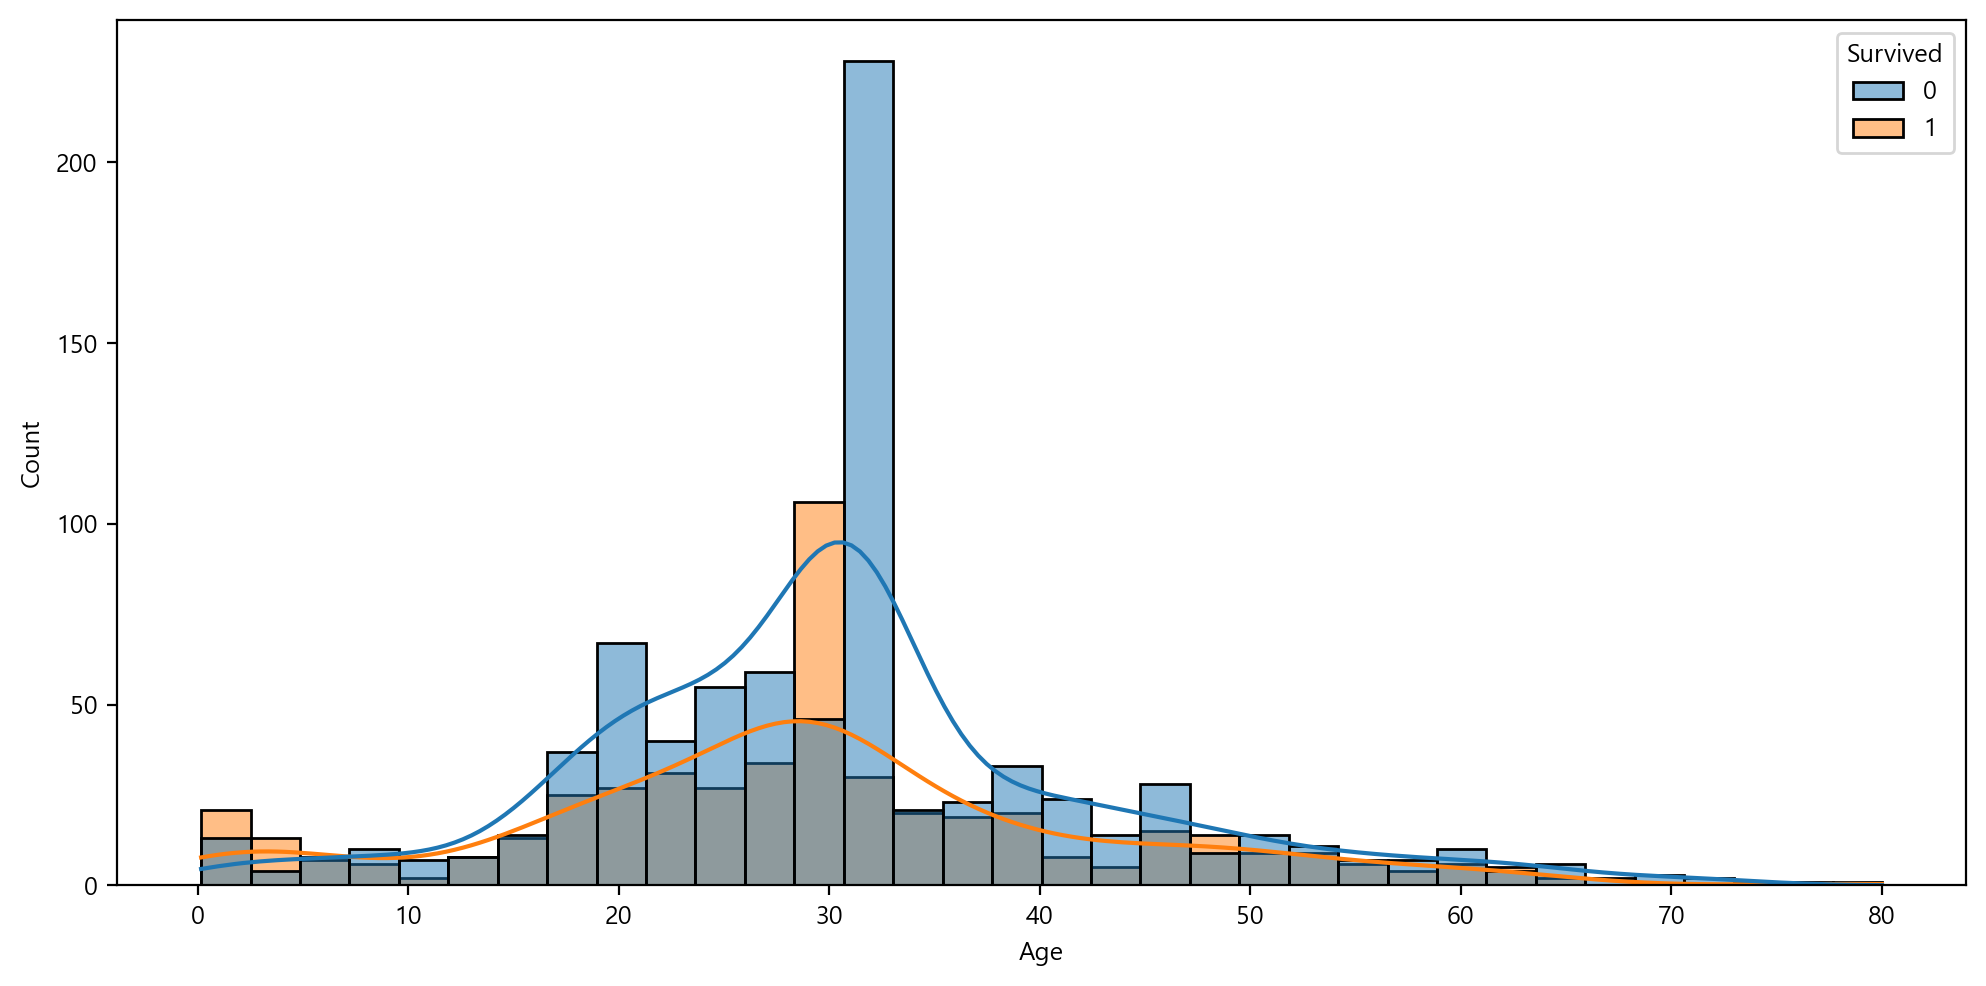

In [6]:
my_histplot(df, 'Age', hue='Survived', dpi=200)

> 분명 생존 여부에 유의미한 차이를 보이는 구간이 있지만, 아직 구간이 너무 많다.

#### (4) 나이의 구간 수를 변경

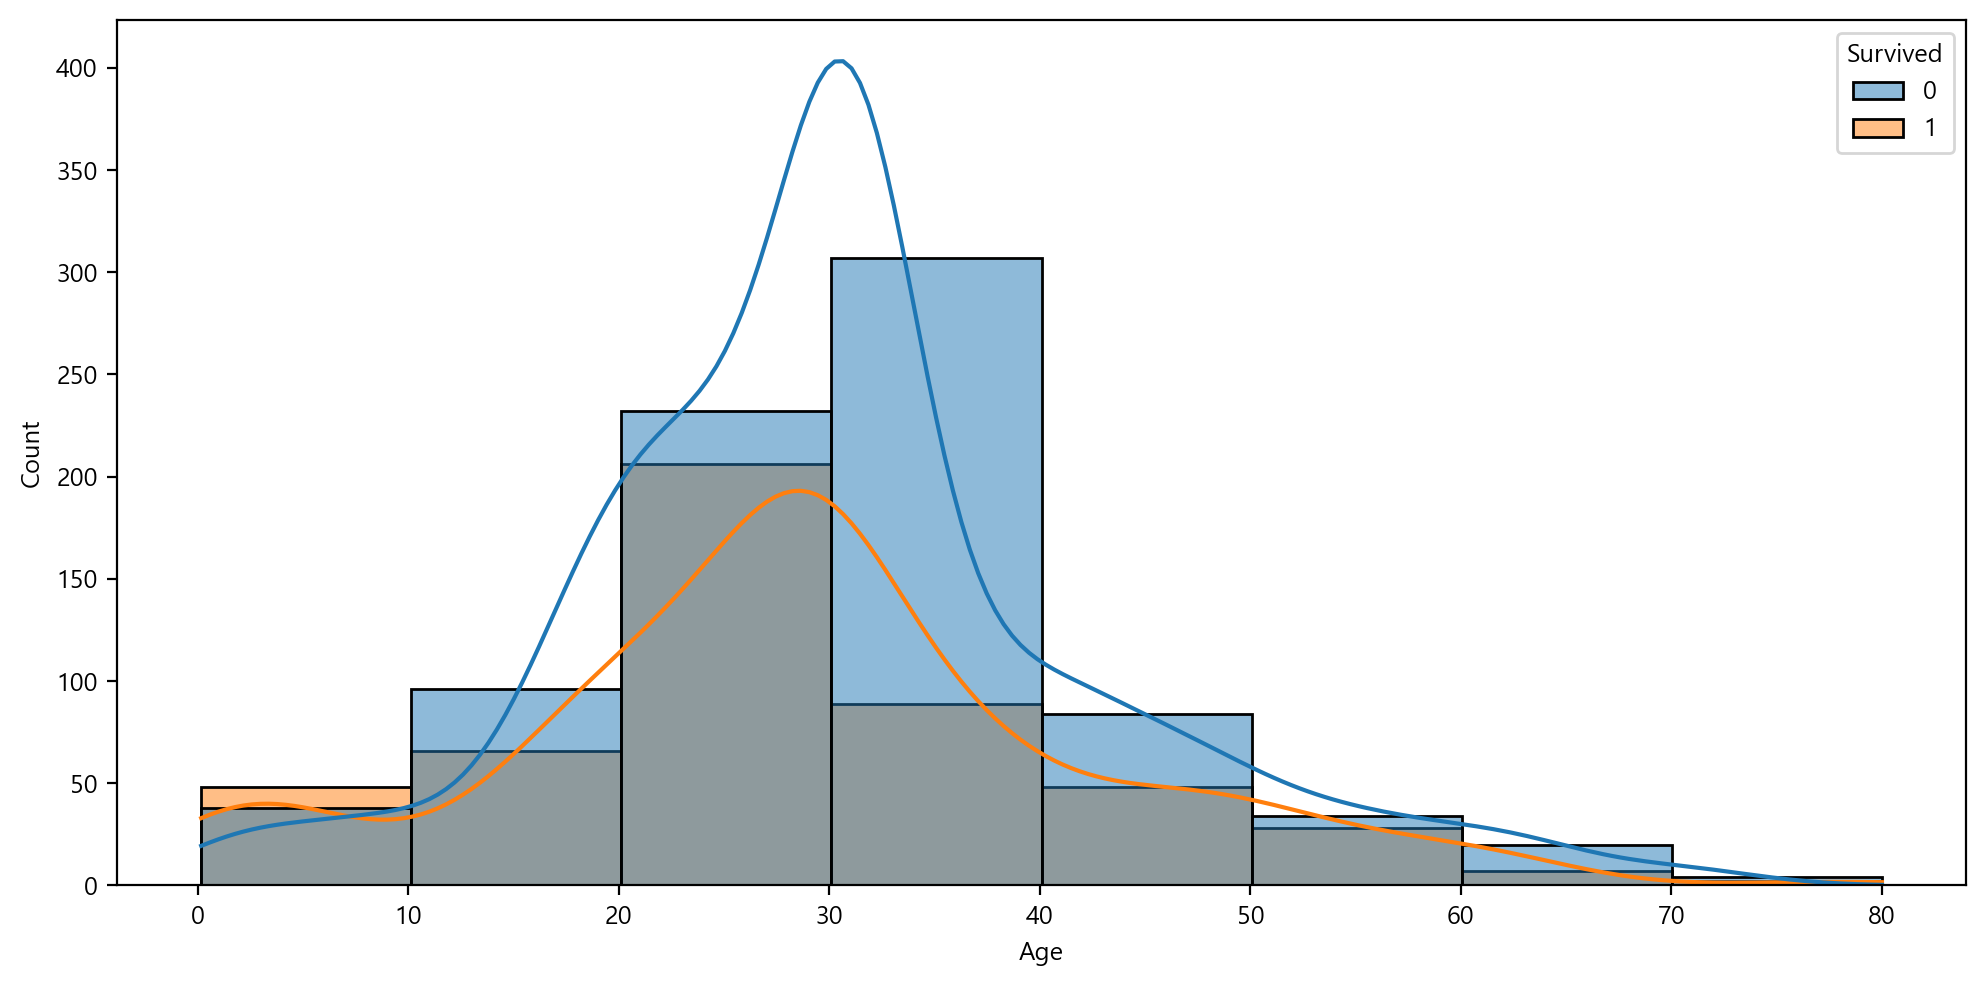

In [7]:
my_histplot(df, 'Age', hue='Survived', bins=8, dpi=200)

> 5개 구간부터 구간 수를 늘려가면서 히스토그램을 확인해 본 결과 5개 구간 이후에 생존자 수가 사망자 수보다 더 많은 구간이 유의미하게 늘어나지 않았다.
>
> 그러므로 5개를 넘는 구간수는 큰 의미가 없는 것으로 보고 나이의 구간을 5개 등급으로 나누기로 결정

#### (5) 나이의 구간에 따른 기준 값 구하기

In [8]:
hist, bins = np.histogram(df['Age'], bins=5)
print(hist)
print(np.round(bins, 0))

[134 787 269 106  13]
[ 0. 16. 32. 48. 64. 80.]


> 16세 이하, 17~32세, 33~48세, 49~64세, 64세 초과 구간으로 나누어 라벨링을 수행

In [9]:
df2 = df.copy()
df2.loc[ df2['Age'] <= 16, "Age"] = 0
df2.loc[ (df2['Age'] > 16) & (df2['Age'] <= 32), "Age"] = 1
df2.loc[ (df2['Age'] > 32) & (df2['Age'] <= 48), "Age"] = 2
df2.loc[ (df2['Age'] > 48) & (df2['Age'] <= 64), "Age"] = 3
df2.loc[ df2['Age'] > 64, "Age"] = 4

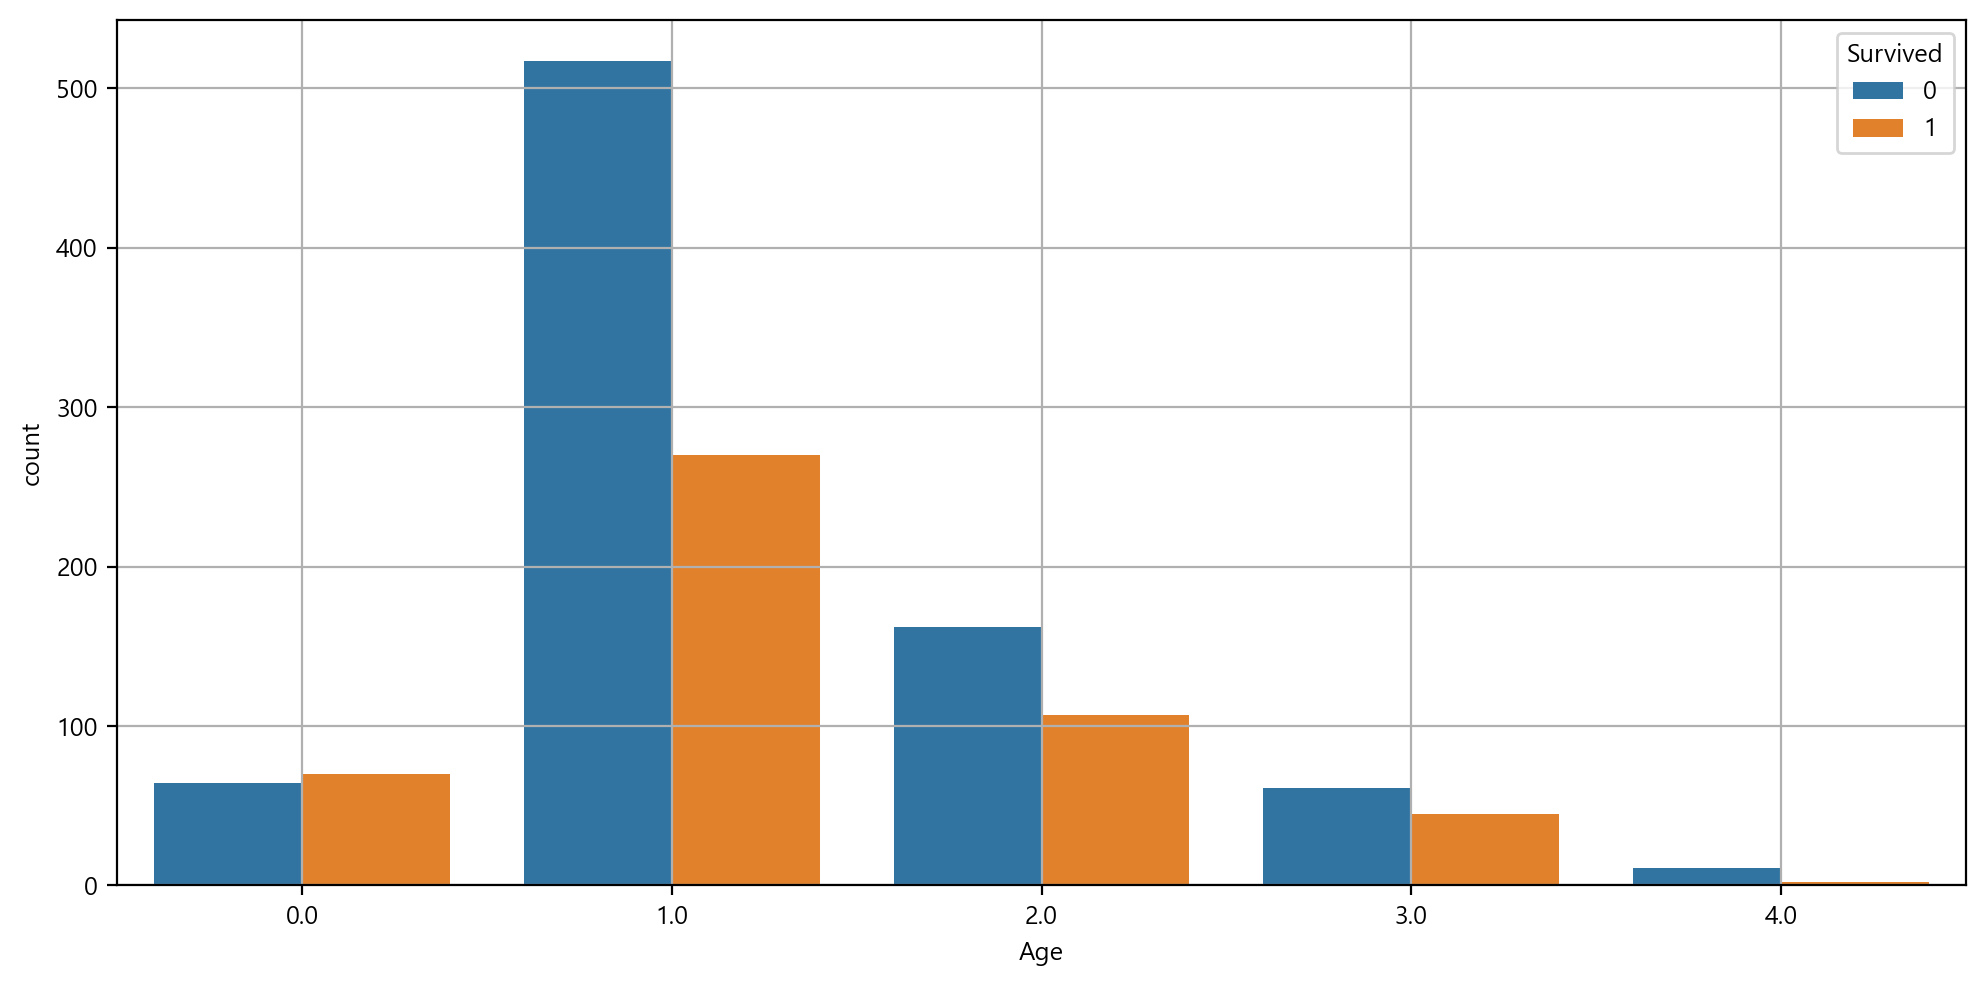

In [10]:
my_countplot(df2, xname='Age', hue='Survived', dpi=200)

> 라벨링 된 나이가 `0`인 구간은 생존자 수가 사망자 수보다 많고, 그 이외의 구간은 사망자 수가 생존자 보다 많다.

### [2] 객실 유무

앞 분석에서는 객실번호 데이터를 제외하고 분석모형을 생성했으나 단순히 객실의 유무만로 명목형 변수를 생성하여 분석에 포함함

#### (1) 명목형 변수 생성

In [11]:
# 데이터 타입이 float라 함은 해당 값이 결측치라는 의미 --> 객실이 없다는 뜻
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x:  0 if type(x) == float else 1)
df2['Has_Cabin'].value_counts()

0    1014
1     295
Name: Has_Cabin, dtype: int64

#### (2) 객실 유무에 따른 생존 비율 비교

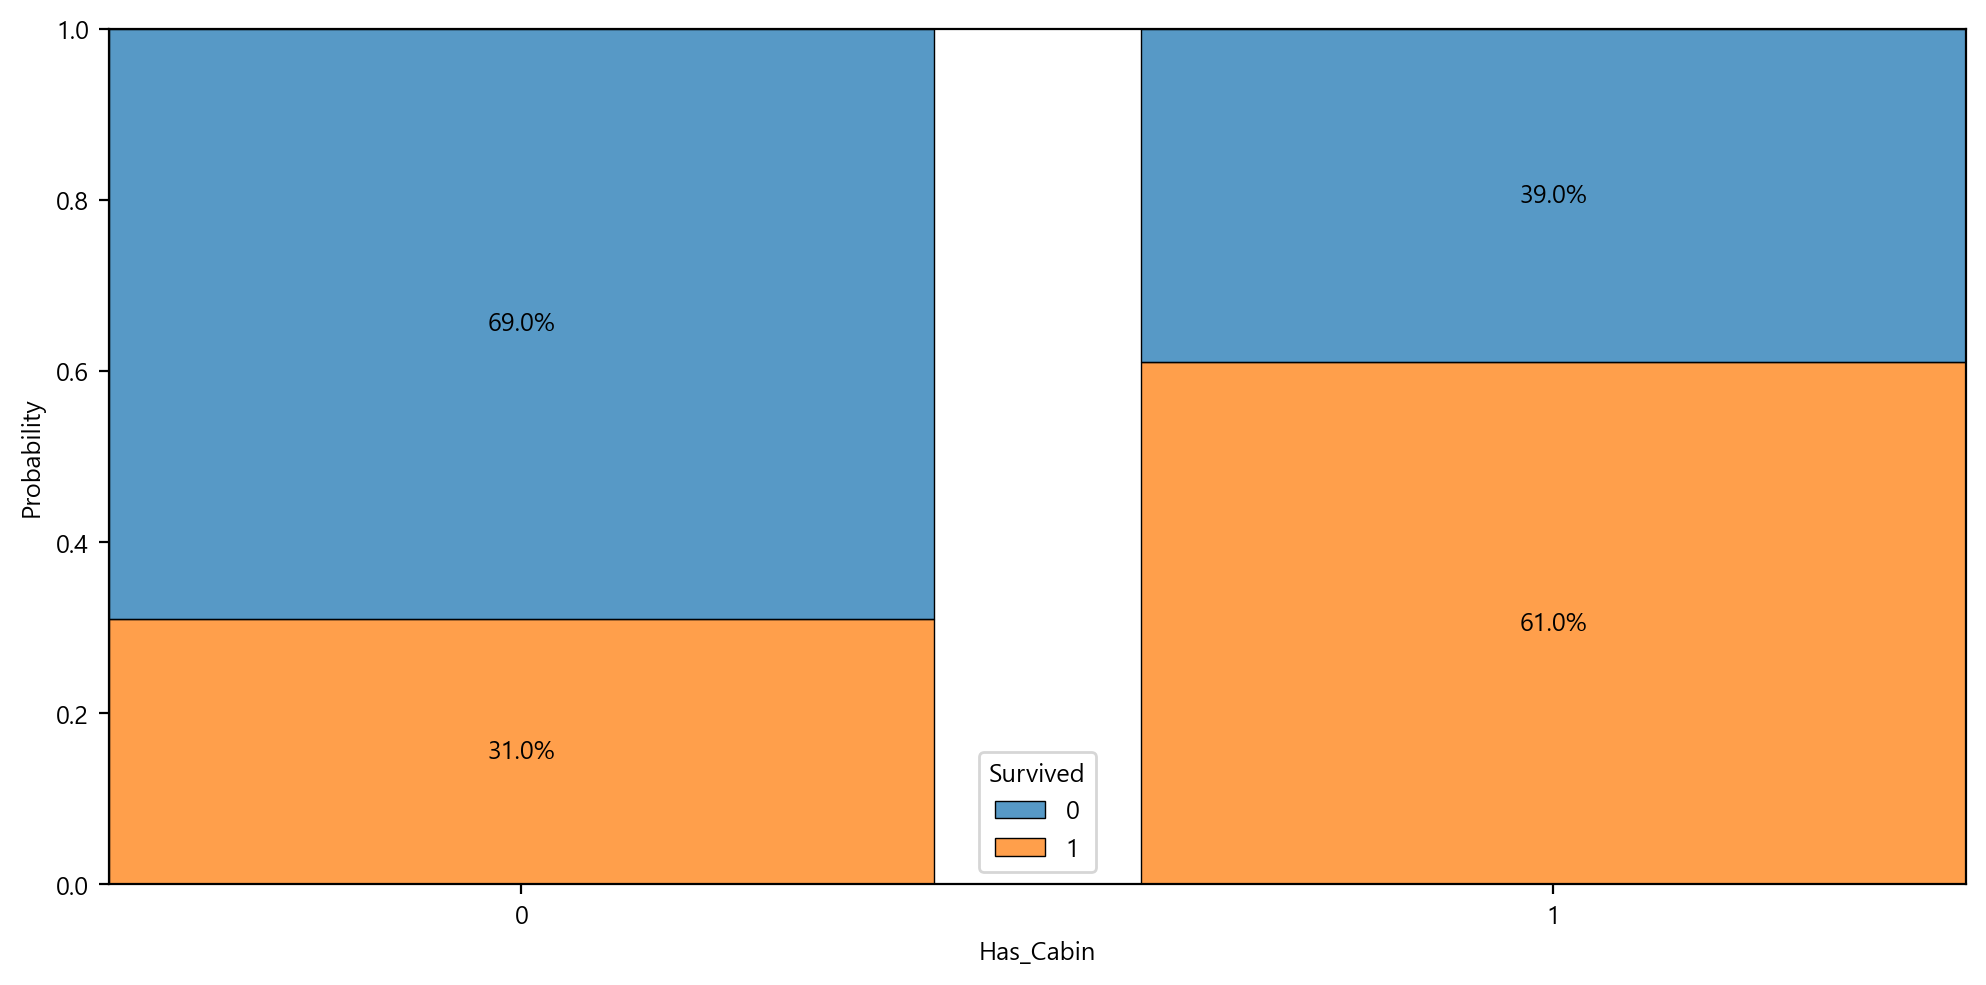

In [12]:
my_stackplot(df2, xname='Has_Cabin', hue='Survived', dpi=200)

> 객실을 배정 받은 탑승객의 생존 비율이 더 높다.

### [3] 가족 구성원 수

형제자매/배우자 + 부모/자녀 + 본인

In [13]:
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

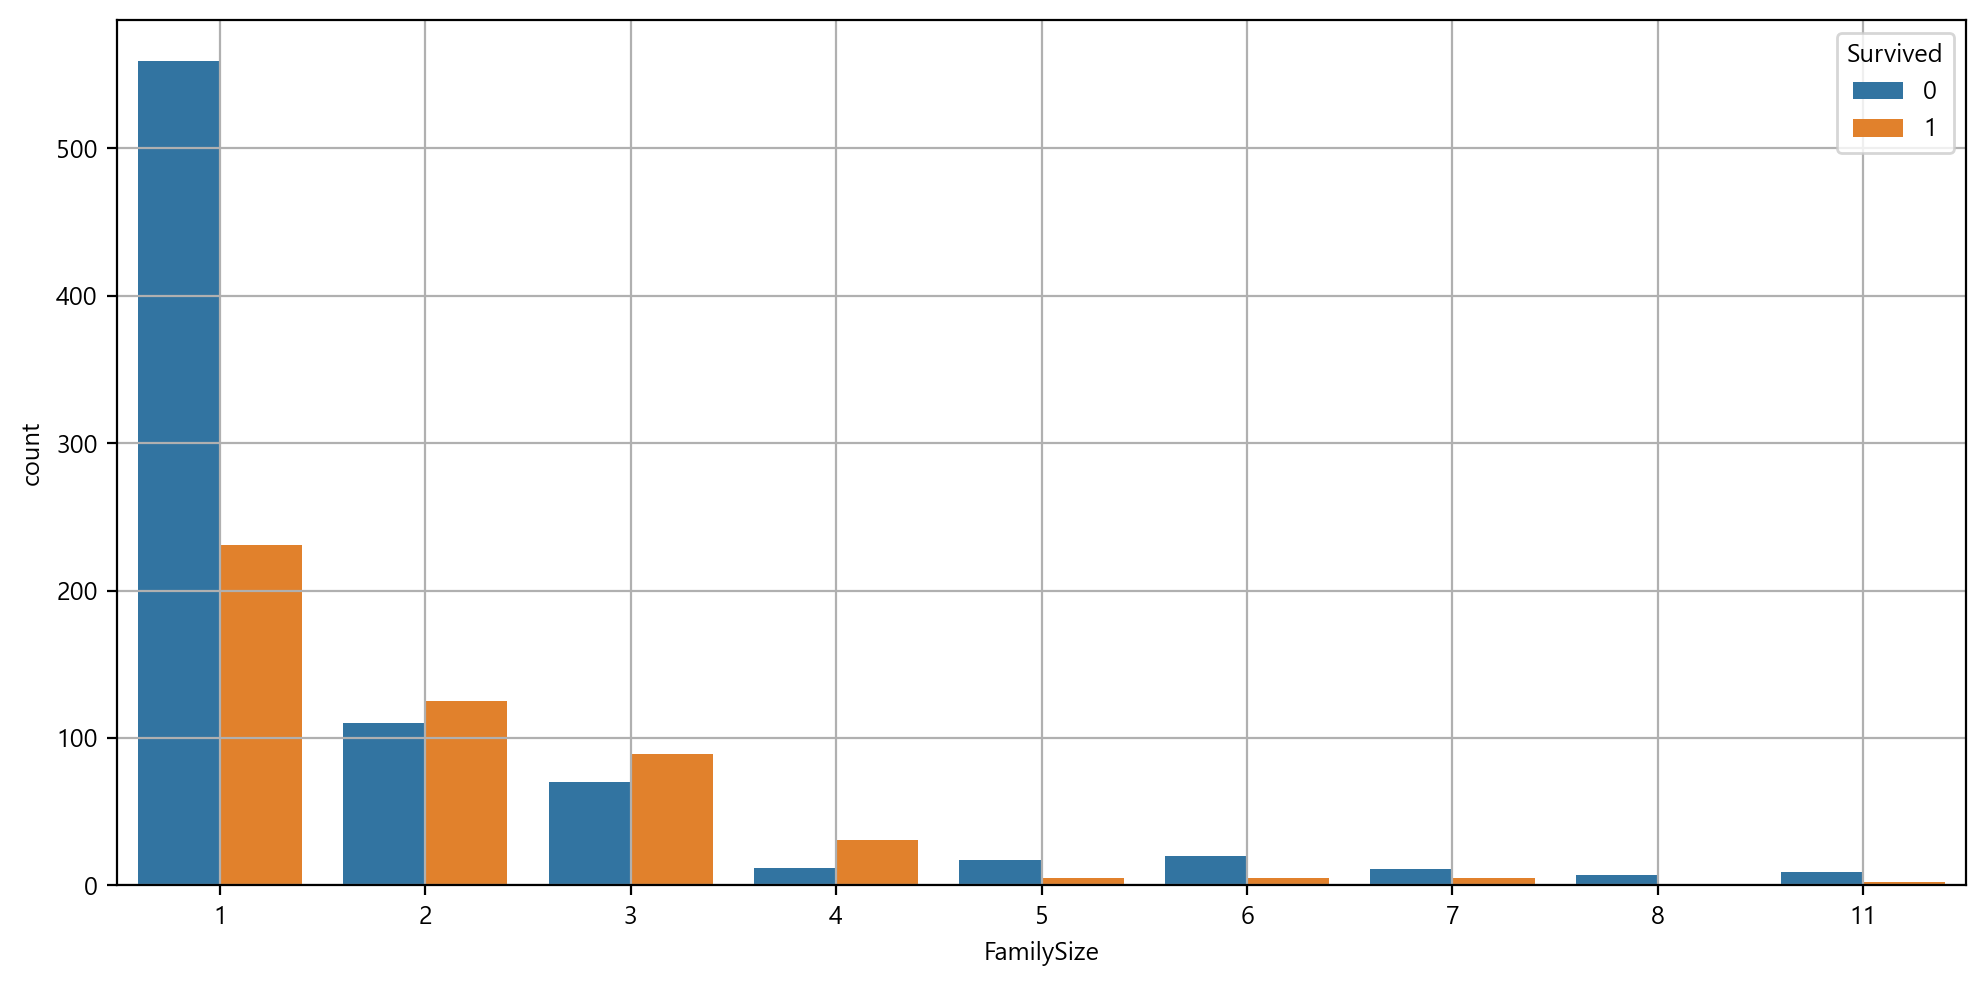

In [14]:
my_countplot(df2, 'FamilySize', hue='Survived', dpi=200)

> 동승한 가족 구성원 수에 따라 생존자가 사망자보다 더 많은 구간이 존재함.
>
> 형제자매/배우자, 부모/자녀 변수는 이 값과 상관관계가 높을 것이 분명하므로 제거하기로 함

### [4] 혼자 탑승했는지 여부

In [15]:
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

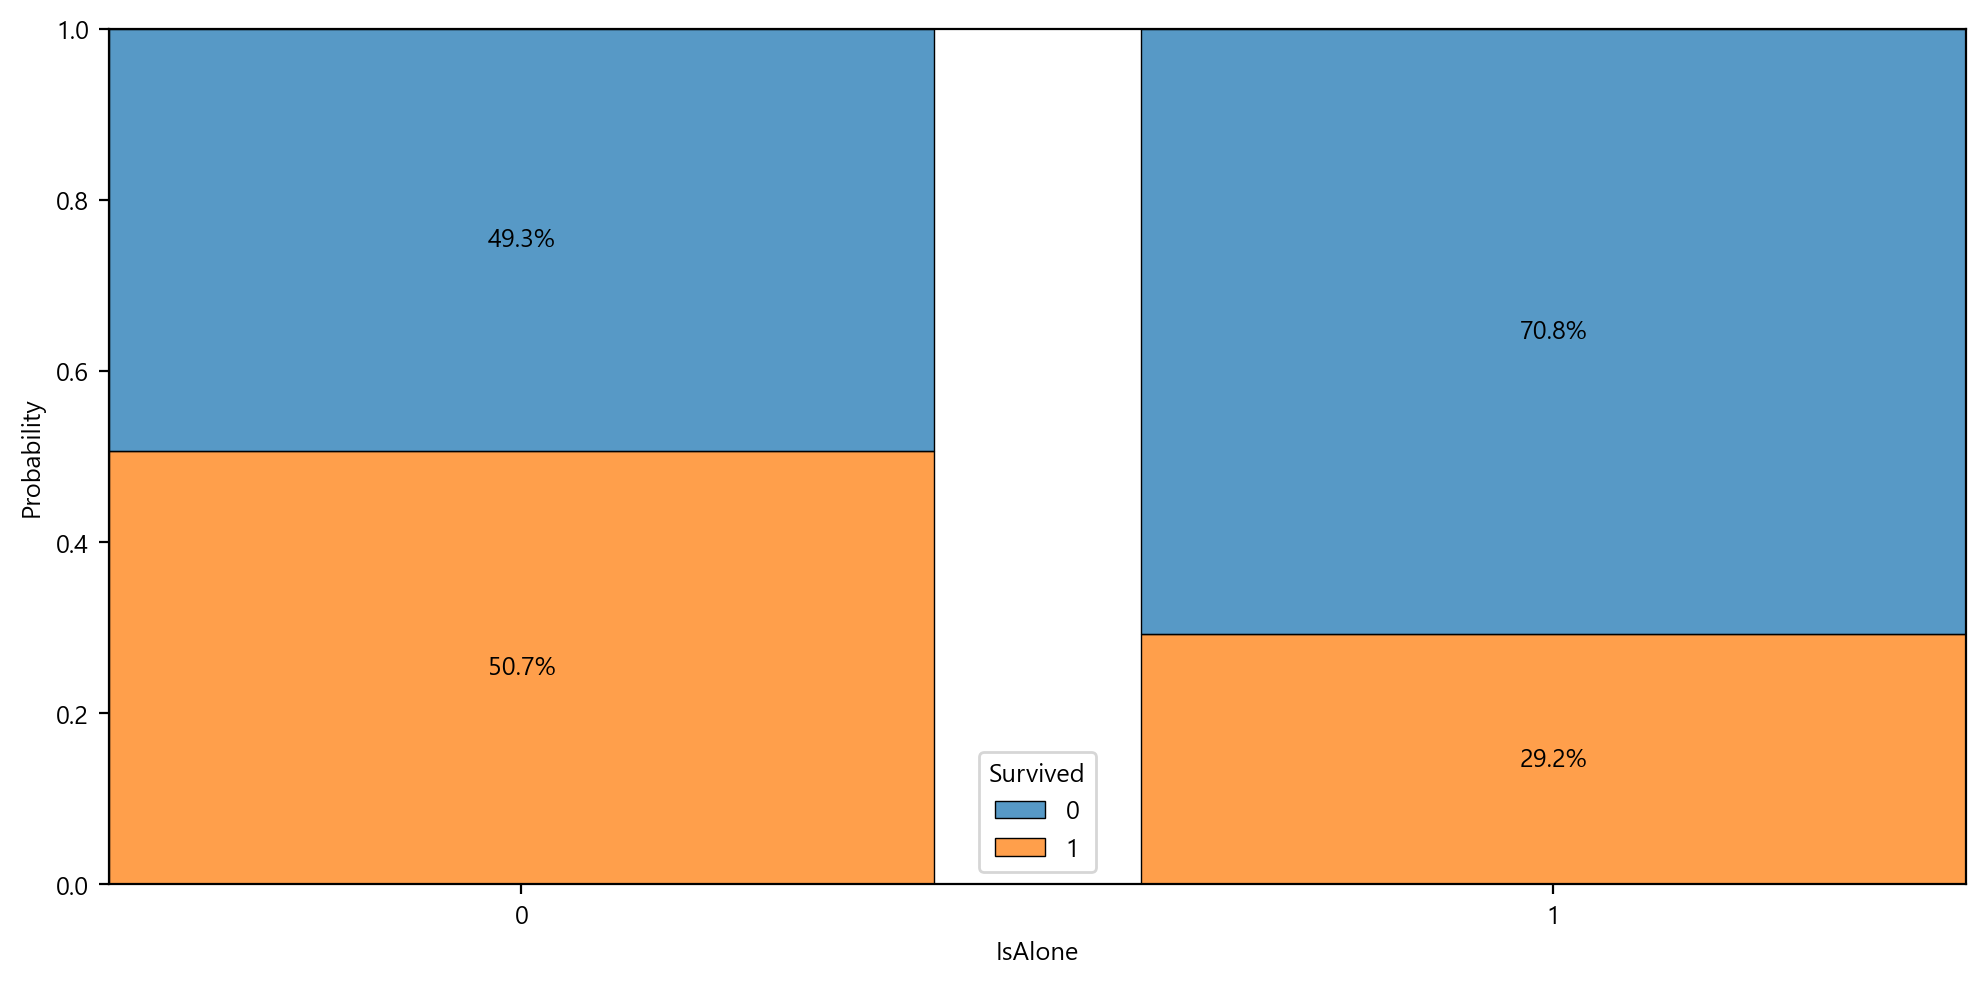

In [16]:
my_stackplot(df2, 'IsAlone', hue='Survived', dpi=200)

> 동승자가 있는 경우가 혼자 탑승한 경우보다 생존 비율이 높다.

### [5] 탑승지 데이터의 결측치 처리

#### (1) 생존, 사망 여부에 따른 최빈값 구하기

In [17]:
most_embarked_df = df2[['Survived','Embarked']].groupby('Survived').agg(Series.mode)
most_embarked_df

,Embarked
Survived,
0,S
1,S


#### (2) 탑승지 결측치에 대한 종속변수를 확인하고 적절한 값으로 대체

In [18]:
for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]['Embarked']
    #print(most)

    expr = (df2['Survived'] == i) & (df2['Embarked'].isna())
    #print(expr)

    df2.loc[expr, 'Embarked'] = df2.loc[expr, 'Embarked'].fillna(most)

df2['Embarked'].isna().sum()

0

### [6] 운임요금에 대한 결측치 처리

#### (1) 결측치 확인

In [19]:
df2['Fare'].isna().sum()

1

#### (2) 생존, 사망 여부에 따라 평균값 구함

In [20]:
mean_fare_df = df2[['Survived','Fare']].groupby('Survived').mean()
mean_fare_df

,Fare
Survived,
0,23.879124
1,48.811497


#### (3) 생존 여부에 따른 평균 요금 대체

In [21]:
for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]['Fare']
    #print(mean_fare)

    expr = (df2['Survived'] == i) & (df2['Fare'].isna())
    #print(expr)

    df2.loc[expr, 'Fare'] = df2.loc[expr, 'Fare'].fillna(mean_fare)

df2['Fare'].isna().sum()

0

### [7] 이름에 대한 처리

#### (1) 정규표현식 처리 함수

이름에서 알파벳을 제외한 나머지 글자를 제외하고 어절단위로 리스트로 묶은 후 인덱스가 1인 위치를 리턴하는 함수

> 예) Mr. Lee --> ['Mr', 'Lee']

In [22]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    
    return ""

#### (2) 이름 앞에 붙은 호칭을 분리

In [23]:
df2['Title'] = df2['Name'].apply(get_title)
df2['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Title, dtype: int64

#### (3) 희귀 호칭은 `기타등등`으로 분류함

In [24]:
df2['Title'] = df2['Title'].replace(['Rev', 'Dr', 
                'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 
                'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona'], "Rare")

df2['Title'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Rare       34
Name: Title, dtype: int64

### [8] 라벨링

In [25]:
df3 = my_labelling(df2, 'Title', 'Embarked', 'Sex')
my_pretty_table(df3.head())

+---------------+------------+----------+-----------------------------------------------------+-------+-------+---------+---------+------------------+---------+---------+------------+-------------+--------------+-----------+---------+
|   PassengerId |   Survived |   Pclass | Name                                                |   Sex |   Age |   SibSp |   Parch | Ticket           |    Fare | Cabin   |   Embarked |   Has_Cabin |   FamilySize |   IsAlone |   Title |
|---------------+------------+----------+-----------------------------------------------------+-------+-------+---------+---------+------------------+---------+---------+------------+-------------+--------------+-----------+---------|
|             1 |          0 |        3 | Braund, Mr. Owen Harris                             |     1 |     1 |       1 |       0 | A/5 21171        |    7.25 | nan     |          2 |           0 |            2 |         0 |       2 |
|             2 |          1 |        1 | Cumings, Mrs. John

### [9] 운임요금에 대한 처리

#### (1) 사분위수 확인

In [26]:
my_outlier_table(df3, 'Fare')

,Q1,Q2,Q3,IQR,UP,DOWN
FIELD,,,,,,
Fare,7.8958,14.4542,31.275,23.3792,66.3438,-27.173


#### (2) 사분위수 구간에 따라 라벨링

In [27]:
df3.loc[ df3['Fare'] <= 7.9, "Fare"] = 0
df3.loc[ (df2['Fare'] > 7.9) & (df3['Fare'] <= 14.5), "Fare"] = 1
df3.loc[ (df3['Fare'] > 14.5) & (df3['Fare'] <= 31.3), "Fare"] = 2
df3.loc[ df3['Fare'] > 31.3, "Fare"] = 3

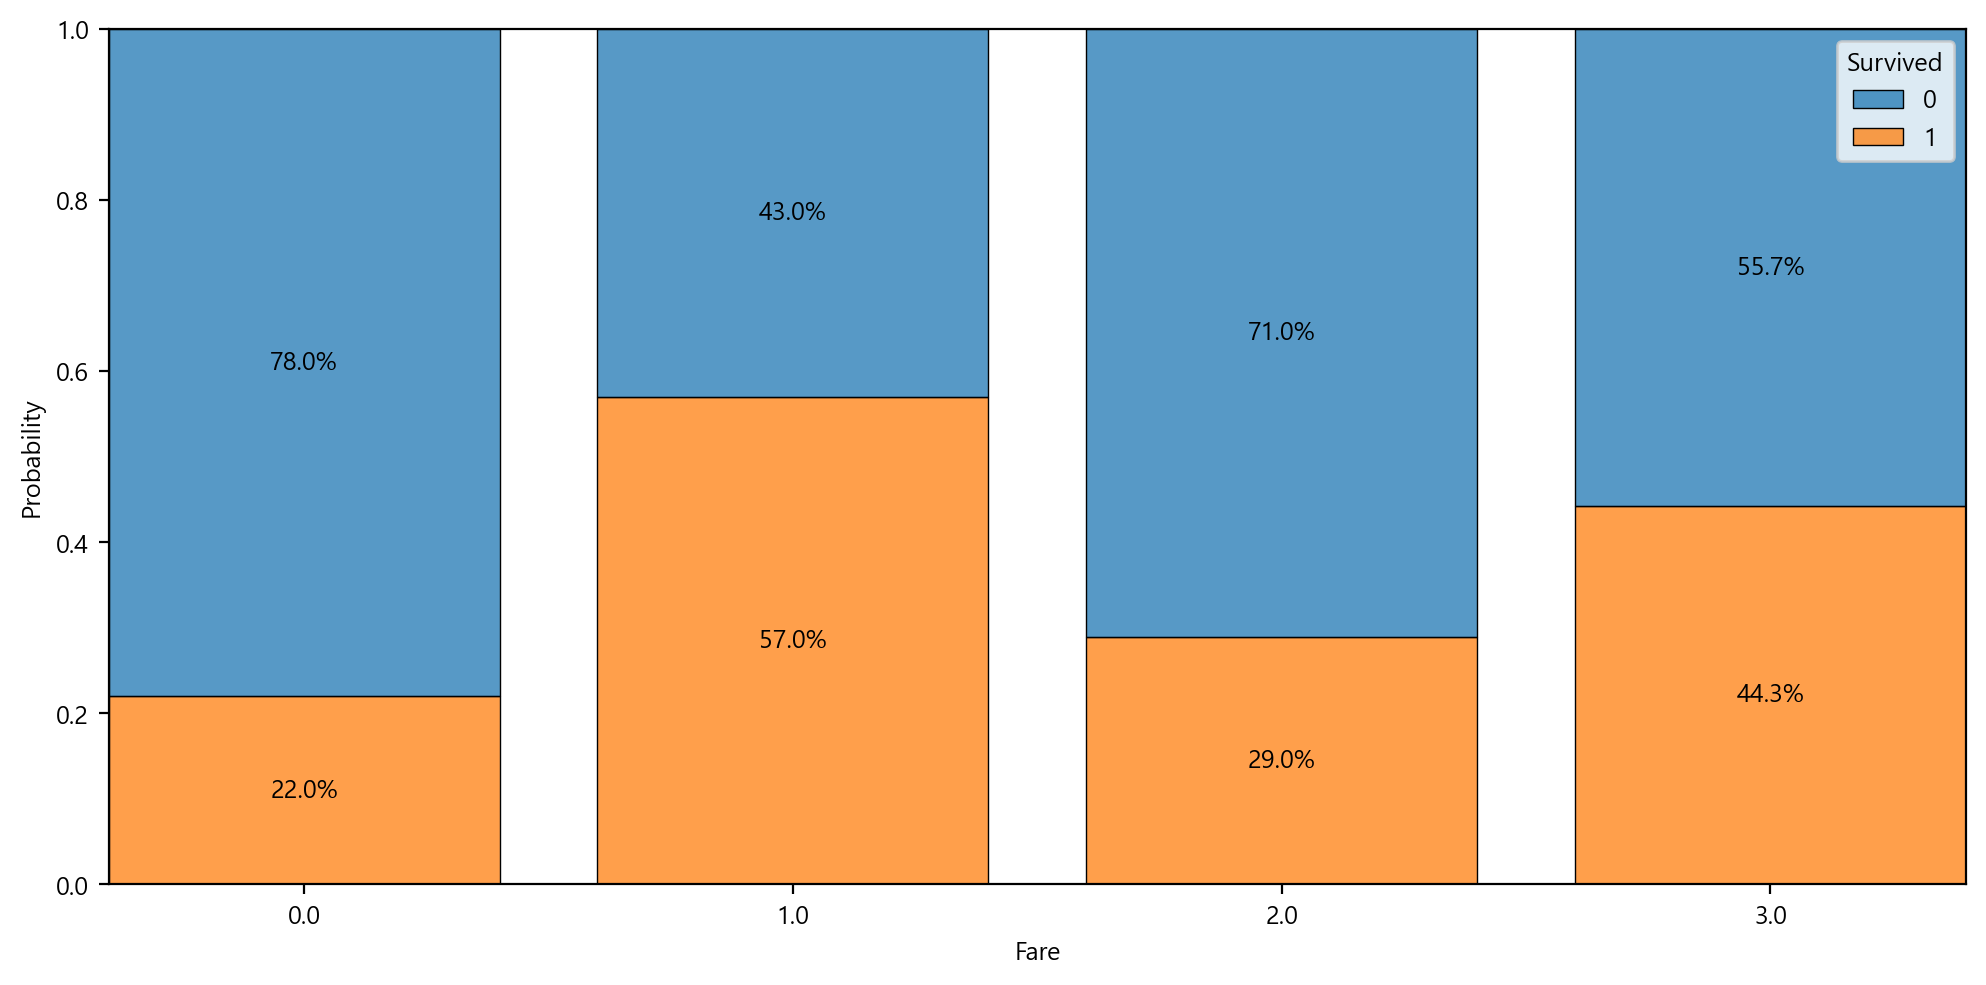

In [28]:
my_stackplot(df3, 'Fare', hue='Survived', dpi=200)

### [10] 불필요한 컬럼 제거

In [29]:
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
df4 = df3.drop(drop_elements, axis = 1)

my_pretty_table(df4.head())

+---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------+
|   PassengerId |   Survived |   Pclass |   Sex |   Age |   Fare |   Embarked |   Has_Cabin |   FamilySize |   IsAlone |   Title |
|---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------|
|             1 |          0 |        3 |     1 |     1 |      0 |          2 |           0 |            2 |         0 |       2 |
|             2 |          1 |        1 |     0 |     2 |      3 |          0 |           1 |            2 |         0 |       3 |
|             3 |          1 |        3 |     0 |     1 |      1 |          2 |           0 |            1 |         1 |       1 |
|             4 |          1 |        1 |     0 |     2 |      3 |          2 |           1 |            2 |         0 |       3 |
|             5 |          0 |        3 |     1 |     2 |      1 |          2 |    

### [11] 훈련/검증 데이터 분리

In [30]:
df4['Survived'] = df4['Survived'].astype('int')
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname='Survived')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1047, 9), (262, 9), (1047,), (262,))

## #03. 로지스틱 회귀 분석

In [31]:
estimator = my_logistic_classification(x_train, y_train, x_test, y_test)